# Model QC Notebook

<img style="float:right;" src="https://id.dewberry.com/clients/Templates/DewberryLogo_RGB.png" width=150px>

### Description
#### - What is needed to use this notebook
  1. adcirc library
  
#### - Steps to follow:
  1. Import Libraries & Assign Paths
  2. Assign Tasks
  3. Save Report

### 1. Import Libraries, Assign Paths, & Variables

In [1]:
from ipywidgets import *
import matplotlib.pyplot as plt # Import the Matplotlib package
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy.interpolate import griddata
import matplotlib.cbook
from adcirc import adcirc
import os
import pandas as pd
import netCDF4 as nc4
from datetime import datetime
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
root_dir = r'/scratch/04952/tmiesse/Dewberry/QC'
f13, f14 = 'fort.13', 'fort.14'
fort13 = adcirc(root_dir,f13)
fort14 = adcirc(root_dir,f14)

### 2. Tasks

#### a. Find the attributes used in the Fort.13 file

In [3]:
attr = fort13.attributes()
attr

,Parameter
0,wave_refraction_in_swan
1,sea_surface_height_above_geoid
2,surface_directional_effective_roughness_length
3,surface_canopy_coefficient
4,mannings_n_at_sea_floor
5,primitive_weighting_in_continuity_equation
6,average_horizontal_eddy_viscosity_in_sea_water...


#### b. Read nodal attributes in fort.13 into a table

In [4]:
table13 = fort13.read_fort13(attr)
table13.head()


 Started finding nodes in attributes at 

2018-07-24 15:42:53.965785
===========END========== 

Processing Time : 
0:01:42.672776


,wave_refraction,sea_surface,surface_directional,surface_canopy,mannings_n,primitive_weighting,average_horizontal
0,1 0.000000,NaN,15490 0.0106490 0.00182500 0.00100000 0.001000...,16299 0.000000,24262 0.0500000,1 0.0200000,1 4.00000
1,2 0.000000,NaN,15491 0.00421200 0.00109300 0.00100000 0.00100...,21471 0.000000,25236 0.0500000,2 0.00500000,2 4.00000
2,3 0.000000,NaN,16297 0.0511780 0.0586370 0.131352 0.00131000 ...,25239 0.000000,25237 0.0370000,3 0.00500000,3 4.00000
3,4 0.000000,NaN,16298 0.0442180 0.0539520 0.0202930 0.0458700 ...,25245 2.27374e-013,25239 0.100000,4 0.00500000,4 4.00000
4,5 0.000000,NaN,16299 0.109154 0.143936 0.173318 0.123676 0.09...,25255 0.000000,25240 0.0370000,5 0.00500000,5 4.00000


#### c. Open and Read the nodes/locations in the fort14

In [5]:
table14 = fort14.read_fort14()
table14.head()

,node_id,node_x,node_y,value
0,1,-60.0400300000,8.5596800000,6.1570001000
1,2,-60.0402700000,8.6642500000,12.8529997000
2,3,-60.0405100000,8.7688200000,25.3540001000
3,4,-60.0409900000,8.9779600000,46.1559982000
4,5,-60.0414700000,9.1871000000,26.4549999000


#### d. Seperate the nodes and data in the fort.13 table 

In [6]:
table = pd.DataFrame.copy(table13)
table = adcirc.seperate_13(table)
table.head()

,sea_surface,wavenodes,wavedata,surfacedir_nodes,e,ese,se,s,sw,wsw,...,ne,ene,surfacenodes,surfacedata,manningsnodes,manningsdata,primitivenodes,primitivedata,averagenodes,averagedata
0,NaN,1,0.000000,15490,0.0106490,0.00182500,0.00100000,0.00100000,0.00100000,0.00100000,...,0.00104400,0.00242100,16299,0.000000,24262,0.0500000,1,0.0200000,1,4.00000
1,NaN,2,0.000000,15491,0.00421200,0.00109300,0.00100000,0.00100000,0.00100000,0.00100000,...,0.00100000,0.00397500,21471,0.000000,25236,0.0500000,2,0.00500000,2,4.00000
2,NaN,3,0.000000,16297,0.0511780,0.0586370,0.131352,0.00131000,0.00136100,0.00138400,...,0.124346,0.0652540,25239,0.000000,25237,0.0370000,3,0.00500000,3,4.00000
3,NaN,4,0.000000,16298,0.0442180,0.0539520,0.0202930,0.0458700,0.00156900,0.00142100,...,0.0808100,0.0702230,25245,2.27374e-013,25239,0.100000,4,0.00500000,4,4.00000
4,NaN,5,0.000000,16299,0.109154,0.143936,0.173318,0.123676,0.0925650,0.0855250,...,0.265285,0.159219,25255,0.000000,25240,0.0370000,5,0.00500000,5,4.00000


### e. Give nodal attribute locations, convert to netcdf, and plot

In [7]:
wave = table[['wavenodes','wavedata']]
table_waves = table14.merge(wave, left_on='node_id',right_on='wavenodes')
table_waves.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

surface_dir = table[['surfacedir_nodes','e','ese','se','s','sw','wsw','w','wnw','nw','n','ne','ene']]
table_surf_dir = table14.merge(surface_dir, left_on='node_id',right_on='surfacedir_nodes')
table_surf_dir.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

surf = table[['surfacenodes','surfacedata']]
table_surf = table14.merge(surf, left_on='node_id',right_on='surfacenodes')
table_surf.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

primitive = table[['primitivenodes','primitivedata']]
table_primitive = table14.merge(primitive, left_on='node_id',right_on='primitivenodes')
table_primitive.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

average = table[['averagenodes','averagedata']]
table_ave = table14.merge(average, left_on='node_id',right_on='averagenodes')
table_ave.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

manning = table[['manningsnodes','manningsdata']]
table_mann = table14.merge(manning, left_on='node_id',right_on='manningsnodes')
table_mann.rename(columns={'node_x':'lon', 'node_y':'lat'}, inplace=True)

In [8]:
# convert attribute table to netcdf
adcirc.input2nc4(root_dir,table_waves)
adcirc.input2nc4(root_dir,table_surf_dir)
adcirc.input2nc4(root_dir,table_surf)
adcirc.input2nc4(root_dir,table_primitive)
adcirc.input2nc4(root_dir,table_ave)
adcirc.input2nc4(root_dir,table_mann)

#### Mannings' n within the study area

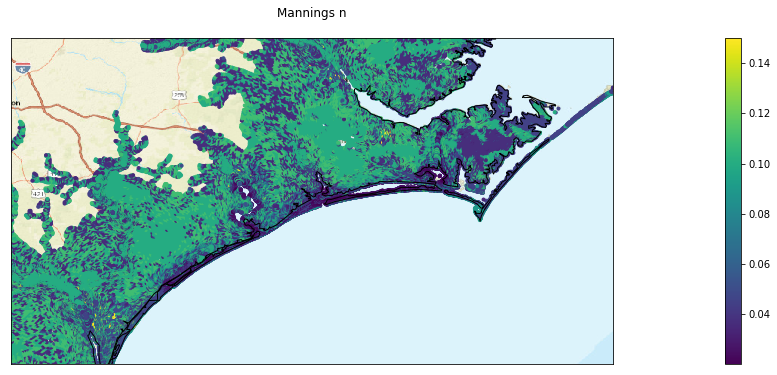

In [24]:
nc = nc4.Dataset('mannings.nc','r')
grp = nc.groups['mannings']
x = grp.variables['Longitude'][:]
y = grp.variables['Latitude'][:]
z = grp.variables['Levels'][:]
data = grp.variables['Data'][:]
fig,ax=plt.subplots(figsize=(48,8))
m = Basemap(projection='cyl',llcrnrlat=34.059,urcrnrlat=35.25,llcrnrlon=-78.25,urcrnrlon=-76.05,resolution='h', epsg = 4269)
m.drawcoastlines(color='k')
plt.title('Mannings n\n')
cmap = matplotlib.cm.get_cmap('viridis')  
normalize = matplotlib.colors.Normalize(vmin=min(data), vmax=max(data))
colors = [cmap(normalize(value)) for value in data]
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose= False)
ax.scatter(x,y,marker = '.', color=colors, zorder=.25)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

#### Surface Canopy Coefficient in the Study Area

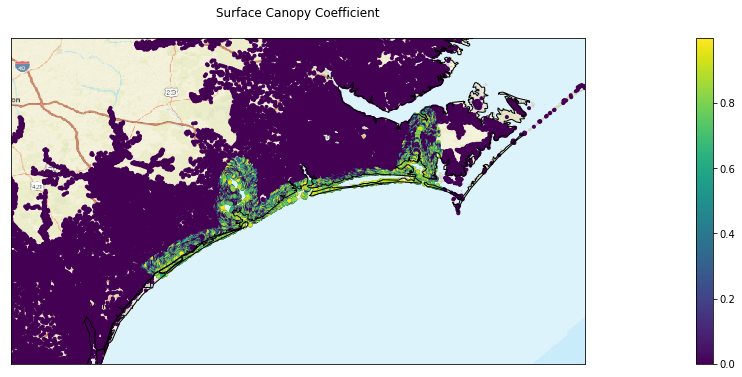

In [25]:
nc = nc4.Dataset('surface.nc','r')
grp = nc.groups['surface']
x = grp.variables['Longitude'][:]
y = grp.variables['Latitude'][:]
z = grp.variables['Levels'][:]
surf = grp.variables['Data'][:]

fig,ax=plt.subplots(figsize=(48,8))
m = Basemap(projection='cyl',llcrnrlat=34,urcrnrlat=35.25,llcrnrlon=-78.25,urcrnrlon=-76.05,resolution='h', epsg = 4269)
m.drawcoastlines(color='k')
plt.title('Surface Canopy Coefficient\n')
cmap = matplotlib.cm.get_cmap('viridis')  
normalize = matplotlib.colors.Normalize(vmin=min(surf), vmax=max(surf))
colors = [cmap(normalize(value)) for value in surf]
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose= False)
ax.scatter(x,y,marker = '.', color=colors, zorder=.25)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

#### Average Horizontal Eddy Viscosity in Sea Water in the Study Area

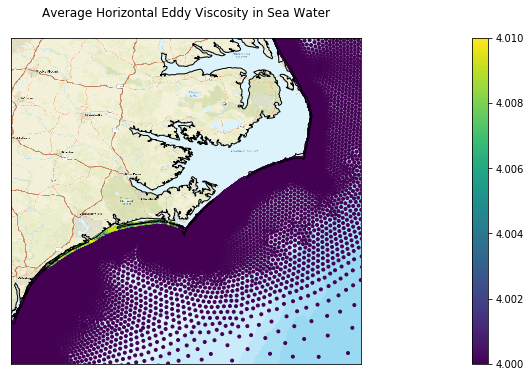

In [27]:
nc = nc4.Dataset('average.nc','r')
grp = nc.groups['average']
x = grp.variables['Longitude'][:]
y = grp.variables['Latitude'][:]
z = grp.variables['Levels'][:]
ave = grp.variables['Data'][:]

fig,ax=plt.subplots(figsize=(48,8))
m = Basemap(projection='cyl',llcrnrlat=33.5,urcrnrlat=36.25,llcrnrlon=-78,urcrnrlon=-75.05,resolution='h', epsg = 4269)
m.drawcoastlines(color='k')
plt.title('Average Horizontal Eddy Viscosity in Sea Water\n')
cmap = matplotlib.cm.get_cmap('viridis')  
normalize = matplotlib.colors.Normalize(vmin=min(ave), vmax=max(ave))
colors = [cmap(normalize(value)) for value in ave]
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose= False)
ax.scatter(x,y,marker = '.', color=colors, zorder=.25)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

#### Primitive Weighting in Continuity Equation in the Study Area

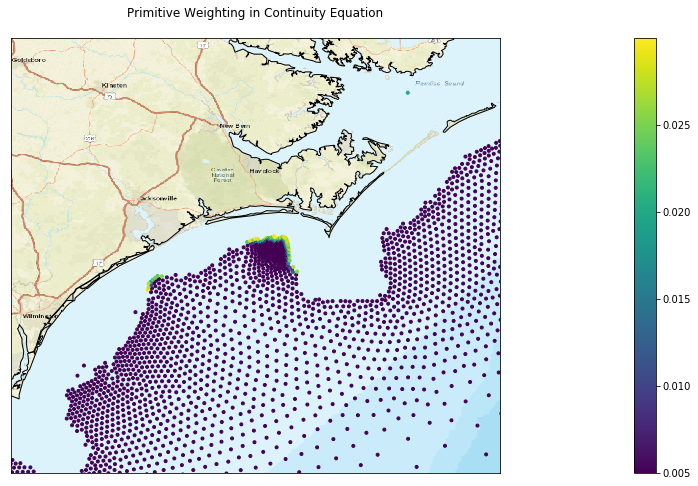

In [30]:
nc = nc4.Dataset('primitive.nc','r')
grp = nc.groups['primitive']
x = grp.variables['Longitude'][:]
y = grp.variables['Latitude'][:]
z = grp.variables['Levels'][:]
prim = grp.variables['Data'][:]

fig,ax=plt.subplots(figsize=(48,8))
m = Basemap(projection='cyl',llcrnrlat=33.5,urcrnrlat=35.5,llcrnrlon=-78,urcrnrlon=-75.75,resolution='h', epsg = 4269)
m.drawcoastlines(color='k')
plt.title('Primitive Weighting in Continuity Equation\n')
cmap = matplotlib.cm.get_cmap('viridis')  
normalize = matplotlib.colors.Normalize(vmin=min(prim), vmax=max(prim))
colors = [cmap(normalize(value)) for value in prim]
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose= False)
ax.scatter(x,y,marker = '.', color=colors, zorder=.25)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

#### Wave Refraction in Swan in the Study Area
- note: not showing points since they are set to 0

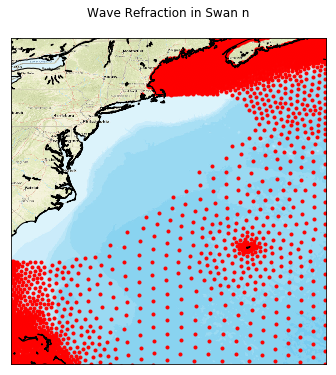

In [26]:
nc = nc4.Dataset('wave.nc','r')
grp = nc.groups['wave']
x = grp.variables['Longitude'][:]
y = grp.variables['Latitude'][:]
z = grp.variables['Levels'][:]
wave = grp.variables['Data'][:]
fig,ax=plt.subplots(figsize=(36,6))
m = Basemap(projection='cyl',llcrnrlat=25.059,urcrnrlat=45.25,llcrnrlon=-79.5,urcrnrlon=-60,resolution='h', epsg = 4269)
m.drawcoastlines(color='k')
plt.title('Wave Refraction in Swan n\n')
#cmap = matplotlib.cm.get_cmap('viridis')  
#normalize = matplotlib.colors.Normalize(vmin=min(wave), vmax=max(wave))
#colors = [cmap(normalize(value)) for value in wave]
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose= False)
m.scatter(x,y,marker = '.', color='r', zorder=.25)
#cax, _ = matplotlib.colorbar.make_axes(ax)
#cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

#### Surface Directional Effective Roughness Length All Directions Plot

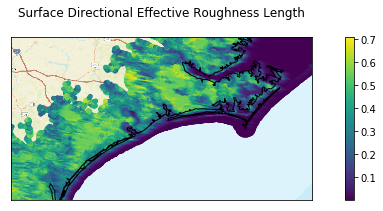

In [13]:
nc = nc4.Dataset('surfacedir.nc','r')
grp = nc.groups['surfacedir']
x = grp.variables['Longitude'][:]
y = grp.variables['Latitude'][:]
z = grp.variables['Levels'][:]
e = grp.variables['E'][:]
ese = grp.variables['ESE'][:]
se = grp.variables['SE'][:]
s = grp.variables['S'][:]
sw = grp.variables['SW'][:]
wsw = grp.variables['WSW'][:]
w = grp.variables['W'][:]
wnw = grp.variables['WNW'][:]
nw = grp.variables['NW'][:]
n = grp.variables['N'][:]
ne= grp.variables['NE'][:]
ene = grp.variables['ENE'][:]

fig,ax=plt.subplots(figsize=(12,3))
m = Basemap(projection='cyl',llcrnrlat=34.059,urcrnrlat=35.25,llcrnrlon=-78.25,urcrnrlon=-76.05,resolution='h', epsg = 4269)
m.drawcoastlines(color='k')
plt.title('Surface Directional Effective Roughness Length\n')
cmap = matplotlib.cm.get_cmap('viridis')  
normalize = matplotlib.colors.Normalize(vmin=min(e), vmax=max(e))
colors = [cmap(normalize(value)) for value in e]
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose= False)
ax.scatter(x,y,marker = '.', color=colors, zorder=.25)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
plt.show()

In [5]:
# Assign date of QC & Name/Info of QC Staff
qc_date = datetime.now()
qc_staff = 'Tyler Miesse'

print('QC Completed on {} by {}'.format(qc_date, qc_staff))

QC Completed on 2018-07-19 09:39:33.396692 by Tyler Miesse


### Export Completed QC Report

## End